In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

# sets the default float-type
tf.keras.backend.set_floatx('float32')

class AxialBar1D:

  def __init__(self, L, E, A, q, N=1000, num_hidden_layers=1, num_neurons_per_layer=20, activation='tanh', actual_solution=None, epochs=5000):

    self.L = L
    self.E = E
    self.N = N
    self.epochs = epochs
    self.xmin = 0
    self.xmax = self.L
    self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
    self.X = self.get_data()
    self.A = A
    self.q = q
    self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,10000],[1e-2,1e-4,5e-5])
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    if actual_solution != None:
      self.actual_solution = actual_solution
    else:
      self.actual_solution = None
  
  def get_data(self):

    X = tf.linspace(start=self.xmin, stop=self.xmax, num=self.N)
    X = tf.expand_dims(X, axis=-1)
    X = tf.cast(X, dtype=tf.float32)
    return X
  
  def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.Input(1))
    # Add the hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation, kernel_initializer='glorot_normal'))
    # Add output layer
    model.add(tf.keras.layers.Dense(1))
    return model
  
  def psi(self, dudx):
    return 0.5*self.A(self.X)*self.E*(dudx**2)
  
  def trapz(self, potential_energy, u):

    h = (self.xmax - self.xmin)/self.N
    integrand = potential_energy - self.q(self.X)*u
    integrand1 = integrand[1:]
    integrand0 = integrand[:-1]
    integral = (h/2)*tf.reduce_sum(integrand1 + integrand0)
    return integral

  def get_loss(self):

    with tf.GradientTape(persistent=True) as tape:
      x = self.X
      x_b = tf.ones((1,1), dtype=tf.float32)*self.L
      tape.watch(x)
      tape.watch(x_b)

      # Find u (output of the model)
      y = self.model(x)
      u = x*self.model(x)
      dudx = tape.gradient(u, x)
      psi_of_x = self.psi(dudx)
      # Perform trapeoidal integration
      # integrand = psi_of_x - self.q*u
      # potential_energy = (self.xmax-self.xmin)*integrand
      integral = self.trapz(psi_of_x, u)

      # get the boundary loss for the natural boundary condition
      y_b = self.model(x_b)
      u_b = x_b*self.model(x_b)
      dudx_b = tape.gradient(u_b, x_b)
    
    loss = integral + tf.square(dudx_b)
    return loss
  
  def get_gradients(self):
    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(self.model.trainable_variables)
      loss = self.get_loss()

    g = tape.gradient(loss, self.model.trainable_variables)
    del tape
    return loss, g
  
  @tf.function
  def train_step(self):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_gradients()
    # Perform gradient descent step
    self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
    return loss
  
  def train(self):
    epochs = self.epochs
    hist = []

    # Start timer
    t0 = time()

    for i in range(epochs+1):
        
        loss = self.train_step()
        # Append current loss to hist
        hist.append(loss.numpy())
        # Output current loss after 50 iterates
        if i%50 == 0:
            print(f'It {i}: loss = {loss[0][0].numpy()}')
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

    # Get the mean_absolute error
    predictions = self.predict(self.X)
    if self.actual_solution != None:
      mae = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X)))
      mse = tf.reduce_mean(tf.square(predictions-self.actual_solution(self.X)))
    else:
      mae = None
      mse = None
    return {'training_history': hist, 'training_time':time()-t0, 'mae': mae, 'mse':mse}
  
  def plot_results(self):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.X)
      predicted_solution = self.X*self.model(self.X)
      predicted_slope = tape.gradient(predicted_solution, self.X)
      plt.figure(figsize=(10, 10))
      plt.plot(self.X, predicted_solution, label='predicted',  color='cyan', linewidth=7 )
      if self.actual_solution != None:
        actual_solution = self.actual_solution(self.X)
        actual_slope = tape.gradient(actual_solution, self.X)
        plt.plot(self.X, actual_solution, label='actual',  linestyle='dashed', color='red', linewidth=7)
      plt.xlabel("X")
      plt.ylabel("u(X)")
      plt.title("Axial Loading Prediction")
      plt.legend()
      # Plot the slope
      plt.figure(figsize=(10, 10))
      plt.plot(self.X, predicted_slope, label='predicted')
      if self.actual_solution != None:
        plt.plot(self.X, actual_slope, label='actual')
      plt.xlabel("X")
      plt.ylabel("du(X)/dx")
      plt.title("Axial Loading Prediction Slope")
      plt.legend()
    
  def predict(self, X):
    return X*self.model.predict(X)


### Consider Axial Bar with q = constant = 10N/m, A = constant = 2 sq.m, N = 1000
we first need to define the functions q, A to be provided as an input to the model

In [ ]:
L = 1
E = 1000

def q(X):
  return tf.ones(shape=X.shape)*100

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=1000,
                   actual_solution=actual_solution,
                   epochs = 60000)

mymodel.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                40        
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mymodel.train()

It 0: loss = 49.73667907714844
It 50: loss = -0.6451695561408997
It 100: loss = -0.792336106300354
It 150: loss = -0.799704372882843
It 200: loss = -0.8063158392906189
It 250: loss = -0.8121762871742249
It 300: loss = -0.8171201348304749
It 350: loss = -0.8211314678192139
It 400: loss = -0.8242851495742798
It 450: loss = -0.8266939520835876
It 500: loss = -0.8284868597984314
It 550: loss = -0.8297866582870483
It 600: loss = -0.8307062983512878
It 650: loss = -0.8313406109809875
It 700: loss = -0.8317673802375793
It 750: loss = -0.8320466876029968
It 800: loss = -0.8322252631187439
It 850: loss = -0.8323359489440918
It 900: loss = -0.8324036598205566
It 950: loss = -0.8324431777000427
It 1000: loss = -0.8324663043022156
It 1050: loss = -0.8324787616729736
It 1100: loss = -0.8324858546257019
It 1150: loss = -0.8324893116950989
It 1200: loss = -0.8324915170669556
It 1250: loss = -0.8324929475784302
It 1300: loss = -0.8324928283691406
It 1350: loss = -0.8324931263923645
It 1400: loss = -0.

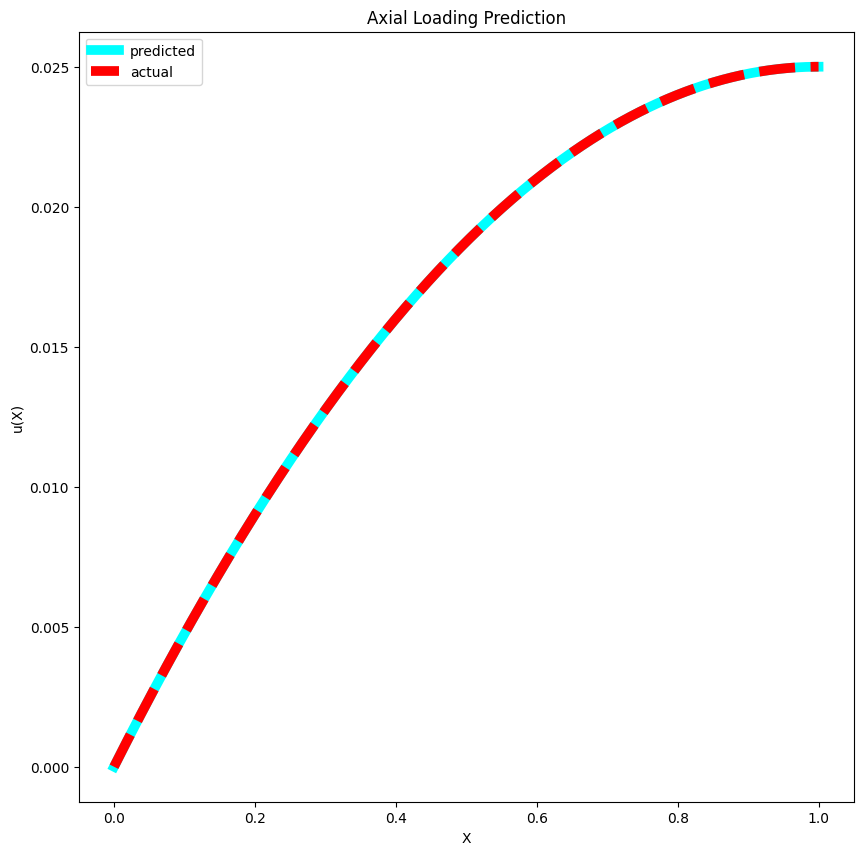

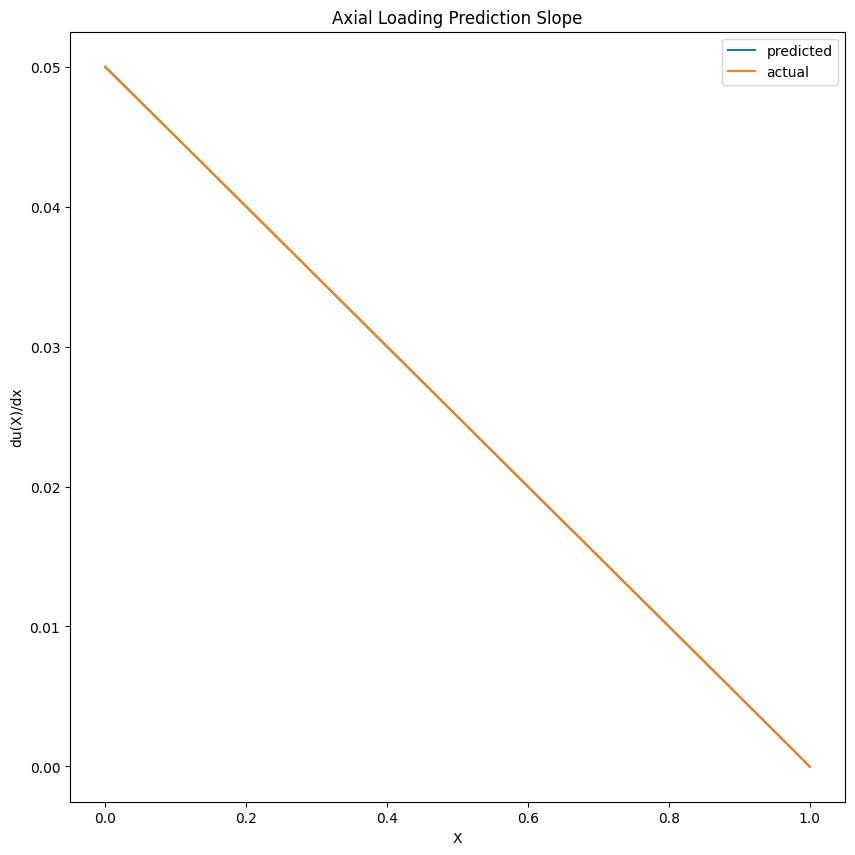

In [ ]:
mymodel.plot_results()

In [ ]:
# Get the training time:
training_time = history['training_time']
mae = history['mae']
mse = history['mse']
print(f'Training time: {training_time}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Training time: 46.836721658706665
Mean Absolute Error: 0.00155536993406713
Mean Squared Error: 4.74534363092971e-06


### Experiment 2

Try increasing the value:
N = 10000
Number of hidden layers = 2

It 0: loss = 521.6104736328125
It 50: loss = -83.3249740600586
It 100: loss = -83.71771240234375
It 150: loss = -83.72559356689453
It 200: loss = -83.72706604003906
It 250: loss = -83.72820281982422
It 300: loss = -83.72904205322266
It 350: loss = -83.72966766357422
It 400: loss = -83.73015594482422
It 450: loss = -83.73053741455078
It 500: loss = -83.73088073730469
It 550: loss = -83.73121643066406
It 600: loss = -83.73155212402344
It 650: loss = -83.73185729980469
It 700: loss = -83.73218536376953
It 750: loss = -83.73251342773438
It 800: loss = -83.73284912109375
It 850: loss = -83.73318481445312
It 900: loss = -83.7335205078125
It 950: loss = -83.7338638305664
It 1000: loss = -83.73418426513672
It 1050: loss = -83.73421478271484
It 1100: loss = -83.73426055908203
It 1150: loss = -83.73429870605469
It 1200: loss = -83.73432159423828
It 1250: loss = -83.73436737060547
It 1300: loss = -83.7343978881836
It 1350: loss = -83.73446655273438
It 1400: loss = -83.7344970703125
It 1450: loss 

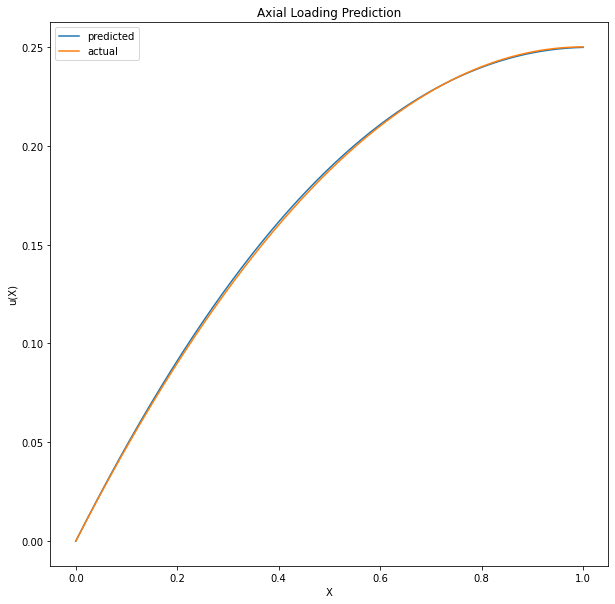

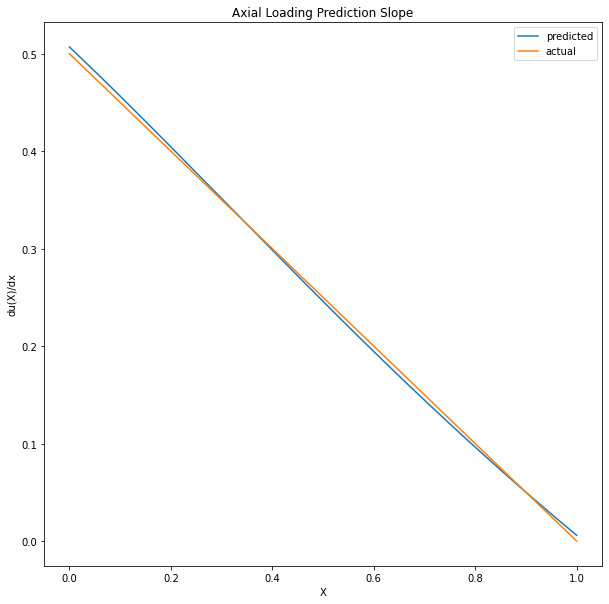

In [ ]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel2 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2)

history2 = mymodel2.train()
mymodel2.plot_results()

# Get the training time:
training_time2 = history2['training_time']
mae2 = history2['mae']
mse2 = history2['mse']
print(f'Training time: {training_time2}')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')

Error actually decreased. However the computation time increased

### Experiment 3
* number of neurons per layer: 40
* number of hidden layers: 2
* number of datapoints (N): 10000



It 0: loss = 97.62186431884766
It 50: loss = -82.99172973632812
It 100: loss = -83.78125
It 150: loss = -83.7997817993164
It 200: loss = -83.80471801757812
It 250: loss = -83.80622863769531
It 300: loss = -83.8066177368164
It 350: loss = -83.80670928955078
It 400: loss = -83.80674743652344
It 450: loss = -83.80679321289062
It 500: loss = -83.80681610107422
It 550: loss = -83.80685424804688
It 600: loss = -83.8068618774414
It 650: loss = -83.80690002441406
It 700: loss = -83.80693054199219
It 750: loss = -83.80696868896484
It 800: loss = -83.80699920654297
It 850: loss = -83.8070297241211
It 900: loss = -83.80706787109375
It 950: loss = -83.8071060180664
It 1000: loss = -83.80714416503906
It 1050: loss = -83.80714416503906
It 1100: loss = -83.80715942382812
It 1150: loss = -83.80714416503906
It 1200: loss = -83.80716705322266
It 1250: loss = -83.80714416503906
It 1300: loss = -83.80716705322266
It 1350: loss = -83.80717468261719
It 1400: loss = -83.80718231201172
It 1450: loss = -83.807

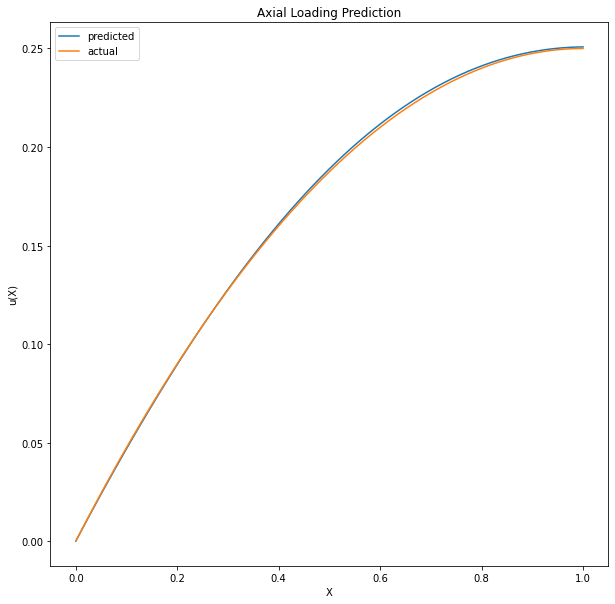

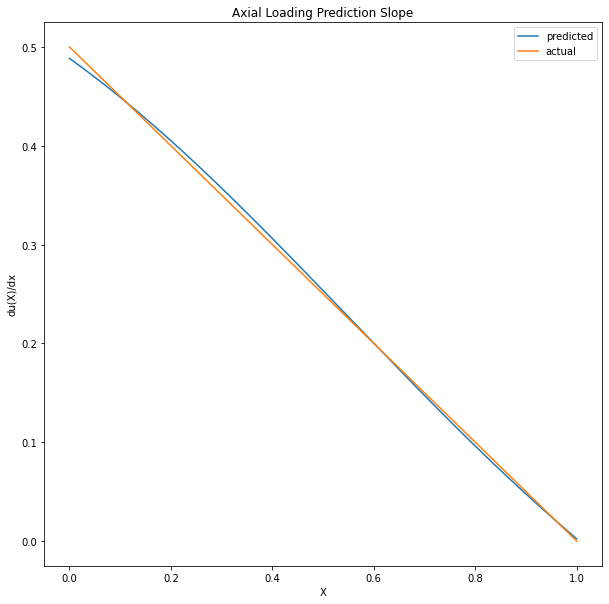

In [ ]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel3 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2,
                   num_neurons_per_layer=40)

history3 = mymodel3.train()
mymodel3.plot_results()

# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')

Error actually increased slightly. This shows that there are uncertainities in this apporach

### Experiment 4: Variable Cross-sectional Area
* number of neurons per layer: 20
* number of hidden layers: 2
* number of datapoints (N): 10000
* A(x) = 1 - (X - L)/L

It 0: loss = -29.5549373626709
It 50: loss = -97.0433349609375
It 100: loss = -97.28569793701172
It 150: loss = -97.34693908691406
It 200: loss = -97.39102935791016
It 250: loss = -97.41062927246094
It 300: loss = -97.41714477539062
It 350: loss = -97.42144775390625
It 400: loss = -97.42594146728516
It 450: loss = -97.43089294433594
It 500: loss = -97.43648529052734
It 550: loss = -97.44303131103516
It 600: loss = -97.45097351074219
It 650: loss = -97.46089935302734
It 700: loss = -97.4735107421875
It 750: loss = -97.4890365600586
It 800: loss = -97.5058364868164
It 850: loss = -97.51917266845703
It 900: loss = -97.52527618408203
It 950: loss = -97.52664184570312
It 1000: loss = -97.52681732177734
It 1050: loss = -97.52681732177734
It 1100: loss = -97.5268325805664
It 1150: loss = -97.52682495117188
It 1200: loss = -97.5268325805664
It 1250: loss = -97.5268325805664
It 1300: loss = -97.5268325805664
It 1350: loss = -97.52684020996094
It 1400: loss = -97.52684020996094
It 1450: loss = -

Training time: 56.56948161125183
Mean Absolute Error: 0.05556821450591087
Mean Squared Error: 0.0036371948663145304


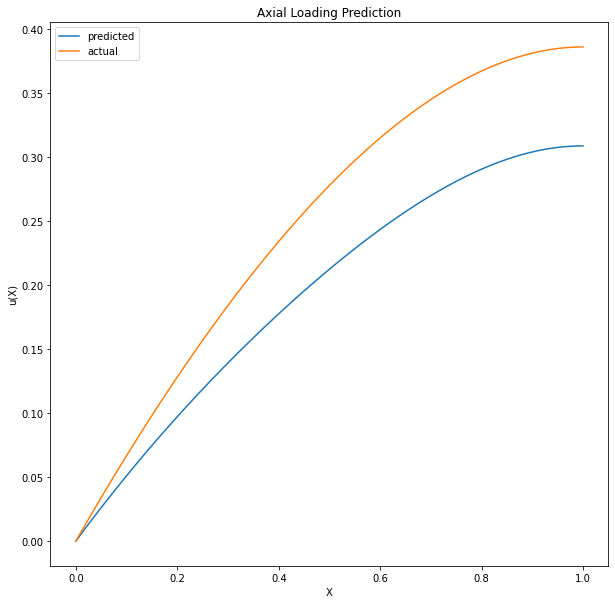

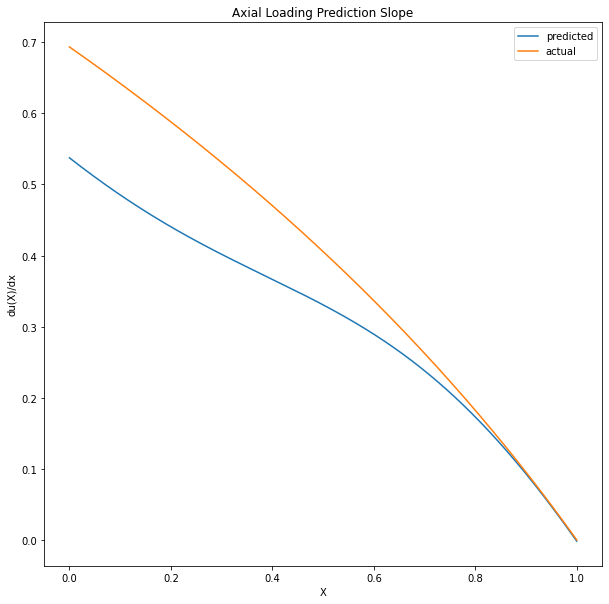

In [ ]:
L = 1
E = 10

def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*(1-(X-L)/L)

def actual_solution(X):
  return (q(X)*L*L/E)*(-(2-X/L)*tf.math.log(2-X/L) - X/L + 2*tf.math.log(2.))

mymodel4 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=2,
                   num_neurons_per_layer=20)

history4 = mymodel4.train()
mymodel4.plot_results()

# Get the training time:
training_time4 = history4['training_time']
mae4 = history4['mae']
mse4 = history4['mse']
print(f'Training time: {training_time4}')
print(f'Mean Absolute Error: {mae4}')
print(f'Mean Squared Error: {mse4}')

It 0: loss = -23.55411720275879
It 50: loss = -84.48646545410156
It 100: loss = -85.77507781982422
It 150: loss = -85.78343200683594
It 200: loss = -85.78348541259766
It 250: loss = -85.78350067138672
It 300: loss = -85.78352355957031
It 350: loss = -85.78355407714844
It 400: loss = -85.7835693359375
It 450: loss = -85.78359985351562
It 500: loss = -85.78363037109375
It 550: loss = -85.78367614746094
It 600: loss = -85.78369140625
It 650: loss = -85.7837142944336
It 700: loss = -85.78376007080078
It 750: loss = -85.78380584716797
It 800: loss = -85.7838363647461
It 850: loss = -85.78388214111328
It 900: loss = -85.78392028808594
It 950: loss = -85.7839584350586
It 1000: loss = -85.78399658203125
It 1050: loss = -85.78401947021484
It 1100: loss = -85.78401947021484
It 1150: loss = -85.78401947021484
It 1200: loss = -85.78401947021484
It 1250: loss = -85.78402709960938
It 1300: loss = -85.78402709960938
It 1350: loss = -85.7840347290039
It 1400: loss = -85.7840347290039
It 1450: loss = -

Training time: 224.8601312637329
Mean Absolute Error: 0.0037141323555260897
Mean Squared Error: 1.6463660358567722e-05


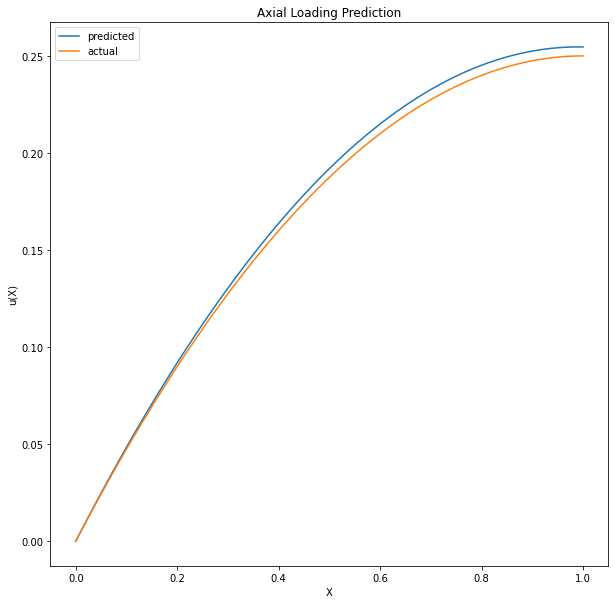

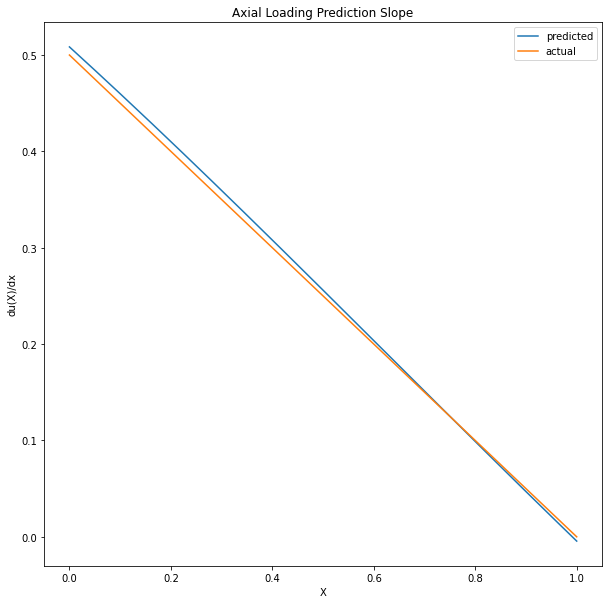

In [ ]:
def q(X):
  return tf.ones(shape=X.shape)*10

def A(X):
  return tf.ones(shape=X.shape)*2

def actual_solution(X):
  return (q(X)*X/(2*A(X)*E))*(2*L - X)

mymodel3 = AxialBar1D(L=L,
                   E=E,
                   A=A,
                   q=q,
                   N=10000,
                   actual_solution=actual_solution,
                   num_hidden_layers=3,
                   num_neurons_per_layer=50)

history3 = mymodel3.train()
mymodel3.plot_results()

# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')

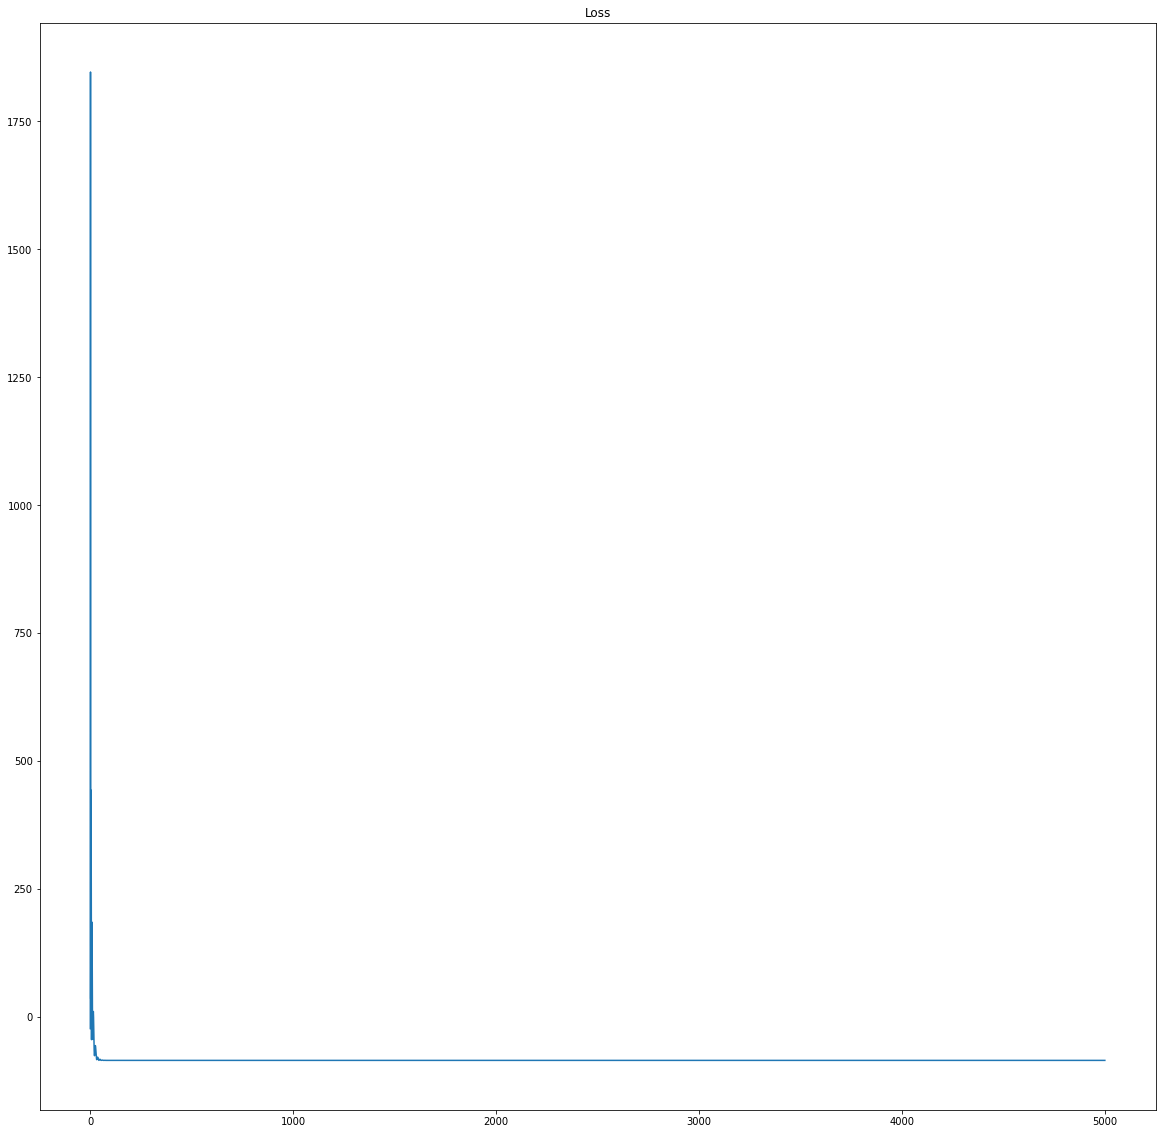

In [ ]:
plt.figure(figsize=(20, 20))
plt.plot(range(5000), tf.squeeze(history3['training_history'])[:-1])
plt.title('Loss')
plt.show()